Exercise 1 <br>
0. Modul imports

In [94]:
import os
import io
import math
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer

1. Clean and prepare the given data

In [95]:
# read the input data into a table
df = pd.read_table('Data1.csv', sep=';')
# df.head()

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


2. Label and store the data

In [90]:
# Label input data with numeric values
labels = df.label.map({'income': 0, 'private': 1,
                           'living': 2, 'standardOfLiving': 3,
                           'finance': 4, 'traffic': 5,
                           'leisure': 6})

3. Extract the relevant features. In this case I choose 'Buchungstag', 'Buchungstext', 'Verwendungszweck', 'Kontonummer', 'BLZ' and 'Betrag'.
Prepare and transform the features so that we can work with them

In [91]:
# Feature Buchungstag => extract day of the week and week of the month 
# convert to datetime
buchungstag = pd.to_datetime(df['Buchungstag'])
day_of_the_week = buchungstag.dt.dayofweek

# calculate the week in the month and use this as an additional feature
week_of_the_month = pd.to_numeric(buchungstag.dt.day/7).apply(lambda x: math.ceil(x))
day_of_the_week = pd.get_dummies(day_of_the_week)
week_of_the_month = pd.get_dummies(week_of_the_month)
features_buchungstag = pd.concat([week_of_the_month, day_of_the_week], axis=1)

# Feature Buchungstext just use the whole word as feature
features_buchungstext = pd.get_dummies(df['Buchungstext'])

# Bag of words for Verwendungszweck
# Optional with german stopwords, but this did not bring any improvement
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# german_stop_words = stopwords.words('german')
# count_vector = CountVectorizer(stop_words=german_stop_words)
count_vector = CountVectorizer()
use_case = df['Verwendungszweck']
count_vector.fit(use_case)
names = count_vector.get_feature_names()

# frequency matrix of the words
use_case_array = count_vector.transform(use_case).toarray()
features_use_case = pd.DataFrame(data=use_case_array, columns=names)

# Feature Kontonummer just us it  direct as features
features_kontonummer = pd.get_dummies(df['Kontonummer'])

# Feature BLZ just us it  direct as features
features_blz =  pd.get_dummies(df['BLZ'])

# Features Betrag with pos or negative value
betraege = df['Betrag']
str_betraege = betraege.apply(lambda x: x.replace(',','.'))
betraege = pd.to_numeric(str_betraege)
pos_neg = (betraege >= 0) * 1
features_betrag = pd.concat([pd.get_dummies(df['Betrag']), pos_neg], axis=1)

# combine features again:
features = pd.concat([features_buchungstag, features_buchungstext, features_use_case,
                      features_kontonummer, features_blz, features_betrag], axis=1)

4. Train the model

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# split data into test and training set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=1)

# maybe split features again into 'Verwendungszweck' and rest to fit
# fit training data and then return the matrix
#training_data = count_vector.fit_transform(x_train)
# transform testing data and return the matrix
#testing_data = count_vector.transform(x_test)

classifier = GaussianNB()
classifier.fit(x_train, y_train.values.ravel())

# predict based on the data
predictions = classifier.predict(x_test)


5. Evaluate the model

In [93]:
# we evaluate the model with multiple metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score: ', format(accuracy_score(y_test, predictions)))

print('Precision score: ', format(precision_score(y_test, predictions, average='weighted')))

print('Recall score: ', format(recall_score(y_test, predictions, average='weighted')))

print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))

# Cross validation
from sklearn.model_selection import cross_val_score

# TODO unsure if this is correct, check labels because we get 1 at start and end
scores = cross_val_score(classifier, features, labels, cv=5)
print(scores)
print(scores.mean())

Accuracy score:  0.9811320754716981
Precision score:  0.9824797843665768
Recall score:  0.9811320754716981
F1 score:  0.9811320754716981
[1.         0.88095238 0.80952381 0.97619048 1.        ]
0.9333333333333333


6. Visualize the results with a confusion matrix

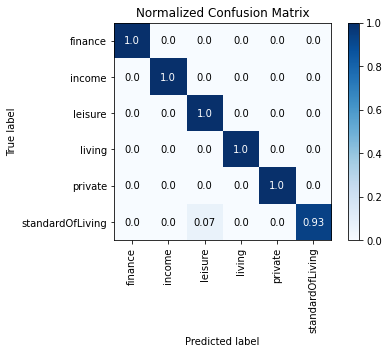

In [37]:
# TODO
import scikitplot as skplt
import matplotlib.pyplot as plt

# map back numeric to label
label_to_text = {0: 'income', 1: 'private',
                           2: 'living', 3 : 'standardOfLiving',
                           4: 'finance', 5: 'traffic',
                           6: 'leisure'}
text_labels = y_test.map(label_to_text)
text_predictions = pd.Series(predictions).map(label_to_text)

# plot a confucsion matrix
skplt.metrics.plot_confusion_matrix(text_labels, text_predictions, normalize=True)
plt.xticks(rotation=90)
plt.show()